In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import re
import import stopwords from nltk
import polars as pl
import json


In [2]:
#Загрузка  и соединение всех данных в один датафрейм (модицифированные функции из бейзлайна)
def load_data(attributes_path, resnet_path, text_and_bert_path, train_path):
    attributes = pd.read_parquet(attributes_path)
    resnet = pd.read_parquet(resnet_path)
    text_and_bert = pd.read_parquet(text_and_bert_path)
    train = pd.read_parquet(train_path)

    return attributes, resnet, text_and_bert, train

def extract_text_from_row(row):

    category_text = ' '.join(
        [' '.join(map(str, v)) if isinstance(v, list) else str(v) for v in list(row['categories'].values())]
    )
    attributes_text = ' '.join(
        [' '.join(map(str, v)) if isinstance(v, list) else str(v) for v in list(row['characteristic_attributes_mapping'].values())]
    )
    return f"{category_text} {attributes_text}"

def process_cat_and_attr(df):
    df['categories'] = df['categories'].apply(json.loads)
    df['characteristic_attributes_mapping'] = df['characteristic_attributes_mapping'].apply(json.loads)
    df['combined_text'] = df.apply(extract_text_from_row, axis=1)
    return df

def merge_data(train, resnet,attributes, text_and_bert):
    data = train.merge(resnet[['variantid', 'main_pic_embeddings_resnet_v1']], left_on='variantid1', right_on='variantid', how='left')
    data = data.rename(columns={'main_pic_embeddings_resnet_v1': 'pic_embeddings_1'})
    data = data.drop(columns=['variantid'])

    data = data.merge(resnet[['variantid', 'main_pic_embeddings_resnet_v1']], left_on='variantid2', right_on='variantid', how='left')
    data = data.rename(columns={'main_pic_embeddings_resnet_v1': 'pic_embeddings_2'})
    data = data.drop(columns=['variantid'])

    data = data.merge(attributes[['variantid', 'combined_text']], left_on='variantid1', right_on='variantid', how='left')
    data = data.rename(columns={'combined_text': 'text_1'})
    data = data.drop(columns=['variantid'])
    data = data.merge(text_and_bert[['variantid', 'name_bert_64', 'description']], left_on='variantid1', right_on='variantid', how='left')
    data = data.rename(columns={'name_bert_64': 'name_bert_1', 'description': 'description_1'})
    data = data.drop(columns=['variantid'])
    data = data.merge(text_and_bert[['variantid', 'name_bert_64', 'description']], left_on='variantid2', right_on='variantid', how='left')
    data = data.rename(columns={'name_bert_64': 'name_bert_2', 'description': 'description_2'})
    data = data.drop(columns=['variantid'])

    data = data.merge(attributes[['variantid', 'combined_text']], left_on='variantid2', right_on='variantid', how='left')
    data = data.rename(columns={'combined_text': 'text_2'})

    data = data.drop(columns=['variantid'])
    print(data.shape[0])
    return data

In [3]:
# Загрузка трейна
path_attr_train = '/Users/annasavitskaya/Desktop/Study/Matching/data/train/attributes.parquet'
path_res_train = '/Users/annasavitskaya/Desktop/Study/Matching/data/train/resnet.parquet'
path_textbert_train = '/Users/annasavitskaya/Desktop/Study/Matching/data/train/text_and_bert.parquet'
path_id_train= '/Users/annasavitskaya/Desktop/Study/Matching/data/train/train.parquet'
attributes_train, resnet_train, text_and_bert_train, train = load_data(path_attr_train,path_res_train, path_textbert_train, path_id_train)

In [9]:
# Загрузка теста
path_attr_test = '/Users/annasavitskaya/Desktop/Study/Matching/data/test/attributes_test.parquet'
path_res_test = '/Users/annasavitskaya/Desktop/Study/Matching/data/test/resnet_test.parquet'
path_textbert_test = '/Users/annasavitskaya/Desktop/Study/Matching/data/test/text_and_bert_test.parquet'
path_id_test= '/Users/annasavitskaya/Desktop/Study/Matching/data/test/test.parquet'
attributes_test, resnet_test, text_and_bert_test, test = load_data(path_attr_test,path_res_test, path_textbert_test, path_id_test)

In [20]:
# Обработка категорий и аттрибутов трейна
attributes_train = process_cat_and_attr(attributes_train)
# Объединяю трейн
train_data = merge_data(train,  resnet_train, attributes_train, text_and_bert_train)

1168516


In [6]:
# Обработка категорий и аттрибутов теста
attributes_test = process_cat_and_attr(attributes_test)
# Объединяю тест
test_data = merge_data(test,  resnet_test, attributes_test, text_and_bert_test)

116851


### Проверка уникальных variant id в test до удаления дублей в train

In [24]:
# ДО УДАЛЕНИЯ ДУБЛЕЙ С РАЗНЫМИ ТАРГЕТАМИ!
# Объединяем значения variantid1 и variantid2 в каждом датафрейме, смотрим униклаьные значения
train_variants = set(train_data['variantid1']).union(set(train_data['variantid2']))
print(len(train_variants))
test_variants = set(set(test_data['variantid1']).union(set(test_data['variantid2'])))
print(len(test_variants))
# Находим пересечения между train и test
common_variants = train_variants.intersection(test_variants)
print(f"Число значений variantid, которые пересекаются: {len(common_variants)}")

unique_test_variants = test_variants.difference(train_variants)
# Вывод результата
print(f"Число уникальных значений variantid в test_data, которых нет в df: {len(unique_test_variants)}")

2155692
231587
Число значений variantid, которые пересекаются: 231587
Число уникальных значений variantid в test_data, которых нет в df: 0


### Удаление дублей 

In [13]:
# Создаем новый столбец с отсортированными значениями variantid1 и variantid2
def delete_duples(df):
    df['sorted_variants'] = df[['variantid1', 'variantid2']].apply(lambda x: tuple(sorted(x)), axis=1)

    # Группируем по столбцу sorted_variants и нахождение групп дубликатов
    duplicate_groups = df[df.duplicated('sorted_variants', keep=False)]

    # Группируем строки по дубликатам и сохраняем индексы и значения target
    grouped_duplicates = duplicate_groups.groupby('sorted_variants').apply(lambda x: {
        'indices': list(x.index),
        'targets': x['target'].tolist()
    })

    # Фильтруем группы, где значения target отличаются
    indices_to_drop = []
    for group, info in grouped_duplicates.items():
        targets = info['targets']
        if len(set(targets)) > 1:  # Если в группе есть более одного уникального значения target
            indices_to_drop.extend(info['indices'])  

    # Удаляем строки с различными target и дубликаты из df
    df.drop(indices_to_drop, inplace=True)
    df.drop_duplicates(subset='sorted_variants', keep='first', inplace=True)

    # Удаляем вспомогательный столбец
    df.drop(columns=['sorted_variants'], inplace=True)

    # Обновленный df
    df.reset_index(drop=True, inplace=True)
    return df


train_data=delete_duples(train_data)

/var/folders/nz/msyc715j0tx2ql6fblq1vm7h0000gn/T/ipykernel_76031/2851992409.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_duplicates = duplicate_groups.groupby('sorted_variants').apply(lambda x: {


### Проверка уникальных variant id в test после удаления дублей в train

In [14]:
#После удаления дублей
# Объединяем значения variantid1 и variantid2 в каждом датафрейме, смотрим униклаьные значения
train_variants = set(train_data['variantid1']).union(set(train_data['variantid2']))
print(len(train_variants))
test_variants = set(test_data['variantid1']).union(set(test_data['variantid2']))
print(len(test_variants))
# Находим пересечения между train и test
common_variants = train_variants.intersection(test_variants)
print(f"Число значений variantid, которые пересекаются: {len(common_variants)}")

unique_test_variants = test_variants.difference(train_variants)
# Вывод результата
print(f"Число уникальных значений variantid в test_data, которых нет в train_data: {len(unique_test_variants)}")

2155106
231587
Число значений variantid, которые пересекаются: 231460
Число уникальных значений variantid в test_data, которых нет в train_data: 127


### Работа с таблицей аттрибутов и категорий

#### Train

In [21]:
# Убираем дубли из таблицы с аттрибутами (дубли удалили, но для один айди может сравниваться в абсолютно разнымих парах )
valid_variant_ids = set(train_data['variantid1']).union(set(train_data['variantid2']))

# Фильтруем строки в attributes_train, оставляя только те, где variantid есть в valid_variant_ids
filtered_attributes_train = attributes_train[attributes_train['variantid'].isin(valid_variant_ids)]

filtered_attributes_train.reset_index(drop=True, inplace=True)


In [44]:
filtered_attributes_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155106 entries, 0 to 2155105
Data columns (total 4 columns):
 #   Column                             Dtype 
---  ------                             ----- 
 0   variantid                          int64 
 1   categories                         object
 2   characteristic_attributes_mapping  object
 3   combined_text                      object
dtypes: int64(1), object(3)
memory usage: 65.8+ MB


In [22]:
# TRAIN
# Извлекаем все уникальных ключи из столбца json_dict
all_keys = filtered_attributes_train['categories'].apply(lambda x: list(x.keys()))

# Объединяем все ключей в один набор уникальных значений
unique_keys = sorted(set([key for sublist in all_keys for key in sublist]))

# Подсчет количества уникальных ключей
num_unique_keys = len(unique_keys)

# Вывод результата
print(f'Уникальные ключи: {unique_keys}')
print(f'Количество уникальных ключей: {num_unique_keys}')

Уникальные ключи: ['1', '2', '3', '4']
Количество уникальных ключей: 4


In [23]:
# Подсчет уникальных значений и их частоты 
for key in unique_keys:
    # Извлечение значений под текущим ключом
    values = attributes_train['categories'].apply(lambda x: x.get(key))

    # Подсчет уникальных значений и их частоты
    unique_values = values.value_counts()

    print(f'Уникальные значения под ключом "{key}": {len(unique_values)}')
    print(f'Значения и их частота под ключом "{key}":\n{unique_values}\n')
    if key=='2':
        list_cat_train=unique_values


Уникальные значения под ключом "1": 3
Значения и их частота под ключом "1":
categories
EPG                       1746039
Одежда и обувь             399531
Книги и цифровые книги     106999
Name: count, dtype: int64

Уникальные значения под ключом "2": 24
Значения и их частота под ключом "2":
categories
Дом и сад                           214851
Одежда                              200703
Обувь                               198828
Строительство и ремонт              198109
Автотовары                          182467
Мебель                              109966
Книги                               106999
Спорт и отдых                       106036
Хобби и творчество                  105321
Электроника                         105162
Галантерея и аксессуары              97068
Красота и гигиена                    71960
Аптека                               71701
Канцелярские товары                  71032
Товары для животных                  70448
Продукты питания                     70270
Детские 

#### Test

In [41]:
attributes_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231587 entries, 2 to 2252512
Data columns (total 4 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   variantid                          231587 non-null  int64 
 1   categories                         231587 non-null  object
 2   characteristic_attributes_mapping  231587 non-null  object
 3   combined_text                      231587 non-null  object
dtypes: int64(1), object(3)
memory usage: 8.8+ MB


In [28]:
# TEST
# Извлечение всех уникальных ключей из столбца json_dict
all_keys_test =attributes_test['categories'].apply(lambda x: list(x.keys()))

# Объединение всех ключей в один набор уникальных значений
unique_keys_test = sorted(set([key for sublist in all_keys_test for key in sublist]))

# Подсчет количества уникальных ключей
num_unique_keys_test = len(unique_keys_test)

# Вывод результата
print(f'Уникальные ключи: {unique_keys_test}')
print(f'Количество уникальных ключей: {num_unique_keys_test}')

Уникальные ключи: ['1', '2', '3', '4']
Количество уникальных ключей: 4


In [29]:

for key in unique_keys_test:
    # Извлечение значений под текущим ключом
    values = attributes_test['categories'].apply(lambda x: x.get(key))

    # Подсчет уникальных значений и их частоты
    unique_values_test = values.value_counts()
    print(f'Уникальные значения под ключом "{key}": {len(unique_values_test)}')
    print(f'Значения и их частота под ключом "{key}":\n{unique_values_test}\n')
    if key=='2':
        list_cat_test=unique_values_test

Уникальные значения под ключом "1": 3
Значения и их частота под ключом "1":
categories
EPG                       179081
Одежда и обувь             41614
Книги и цифровые книги     10892
Name: count, dtype: int64

Уникальные значения под ключом "2": 21
Значения и их частота под ключом "2":
categories
Дом и сад                  21577
Обувь                      20967
Строительство и ремонт     20908
Одежда                     20647
Автотовары                 19695
Книги                      10892
Мебель                     10840
Спорт и отдых              10759
Электроника                10600
Галантерея и аксессуары    10464
Хобби и творчество         10340
Детские товары              7244
Красота и гигиена           7237
Продукты питания            7156
Канцелярские товары         7150
Аптека                      7087
Бытовая химия               7063
Бытовая техника             7005
Товары для животных         6990
Товары для взрослых         6965
Ювелирные изделия              1
Name: 

In [30]:
print(list_cat_train)

categories
Дом и сад                           214851
Одежда                              200703
Обувь                               198828
Строительство и ремонт              198109
Автотовары                          182467
Мебель                              109966
Книги                               106999
Спорт и отдых                       106036
Хобби и творчество                  105321
Электроника                         105162
Галантерея и аксессуары              97068
Красота и гигиена                    71960
Аптека                               71701
Канцелярские товары                  71032
Товары для животных                  70448
Продукты питания                     70270
Детские товары                       69399
Бытовая техника                      69197
Товары для взрослых                  66991
Бытовая химия                        66051
Ювелирные изделия                        5
Антиквариат и коллекционирование         2
Автомототехника                          2


In [31]:
print(list_cat_test)

categories
Дом и сад                  21577
Обувь                      20967
Строительство и ремонт     20908
Одежда                     20647
Автотовары                 19695
Книги                      10892
Мебель                     10840
Спорт и отдых              10759
Электроника                10600
Галантерея и аксессуары    10464
Хобби и творчество         10340
Детские товары              7244
Красота и гигиена           7237
Продукты питания            7156
Канцелярские товары         7150
Аптека                      7087
Бытовая химия               7063
Бытовая техника             7005
Товары для животных         6990
Товары для взрослых         6965
Ювелирные изделия              1
Name: count, dtype: int64


In [32]:
# В трейне на 3 категории "2 уровня " больше, выводим их
values_not_in_test = set(list_cat_train.index) - set(list_cat_test.index)

print(f'Значения, которых нет во тестовом датасете (категория 2): {values_not_in_test}')

Значения, которых нет во тестовом датасете (категория 2): {'Антиквариат и коллекционирование', 'Автомототехника', 'Фермерское хозяйство'}


In [34]:
# Определяем значения, которые ищем под ключом 2
target_values = {'Антиквариат и коллекционирование', 'Автомототехника', 'Фермерское хозяйство'}

# Фильтрация строк, где под ключом 2 в столбце 'categories' находятся нужные значения
filtered_variants = filtered_attributes_train[
   filtered_attributes_train['categories'].apply(lambda x: x.get('2') in target_values)
]['variantid']


print(f"VariantID, в которых под ключом 2 находятся заданные значения:\n{filtered_variants.tolist()}")


VariantID, в которых под ключом 2 находятся заданные значения:
[1083334459, 317662401, 863946390, 514715802, 833622492]


In [36]:
# Фильтрация строк, где variantid содержится в списке отфильтрованных значений
filtered_rows = filtered_attributes_train[filtered_attributes_train['variantid'].isin(filtered_variants)]

# Вывод отфильтрованных строк датафрейма
print(filtered_rows)


          variantid                                         categories  \
604531   1083334459  {'1': 'EPG', '2': 'Антиквариат и коллекциониро...   
732452    317662401  {'1': 'EPG', '2': 'Антиквариат и коллекциониро...   
845998    863946390  {'1': 'EPG', '2': 'Фермерское хозяйство', '3':...   
992988    514715802  {'1': 'EPG', '2': 'Автомототехника', '3': 'Авт...   
1119625   833622492  {'1': 'EPG', '2': 'Автомототехника', '3': 'Авт...   

                         characteristic_attributes_mapping  \
604531   {'Цвет товара': ['золотой'], 'Комплектация': [...   
732452   {'Цвет товара': ['хаки'], 'Сохранность': ['Оче...   
845998   {'Единиц в одном товаре': ['1'], 'Состав': ['с...   
992988   {'Размер упаковки (Длина х Ширина х Высота), с...   
1119625  {'Цвет товара': ['голубой'], 'Количество в упа...   

                                             combined_text  
604531   EPG Антиквариат и коллекционирование Коллекцио...  
732452   EPG Антиквариат и коллекционирование Антиквари...  

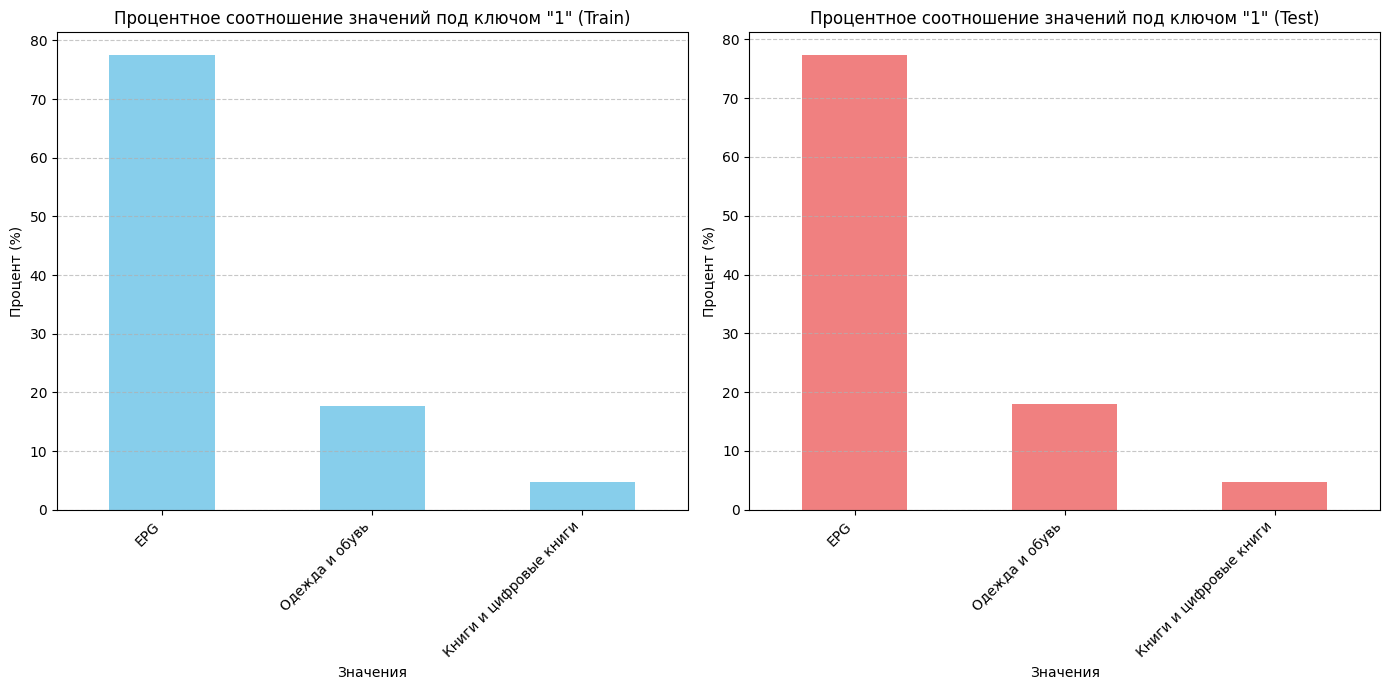

Ключ: "1"
Тренировочный датасет - Уникальные значения и их частота:
categories
EPG                       1746039
Одежда и обувь             399531
Книги и цифровые книги     106999
Name: count, dtype: int64

Тестовый датасет - Уникальные значения и их частота:
categories
EPG                       179081
Одежда и обувь             41614
Книги и цифровые книги     10892
Name: count, dtype: int64

Тренировочный датасет - Процентное соотношение:
categories
EPG                       77.513230
Одежда и обувь            17.736682
Книги и цифровые книги     4.750088
Name: count, dtype: float64

Тестовый датасет - Процентное соотношение:
categories
EPG                       77.327743
Одежда и обувь            17.969057
Книги и цифровые книги     4.703200
Name: count, dtype: float64



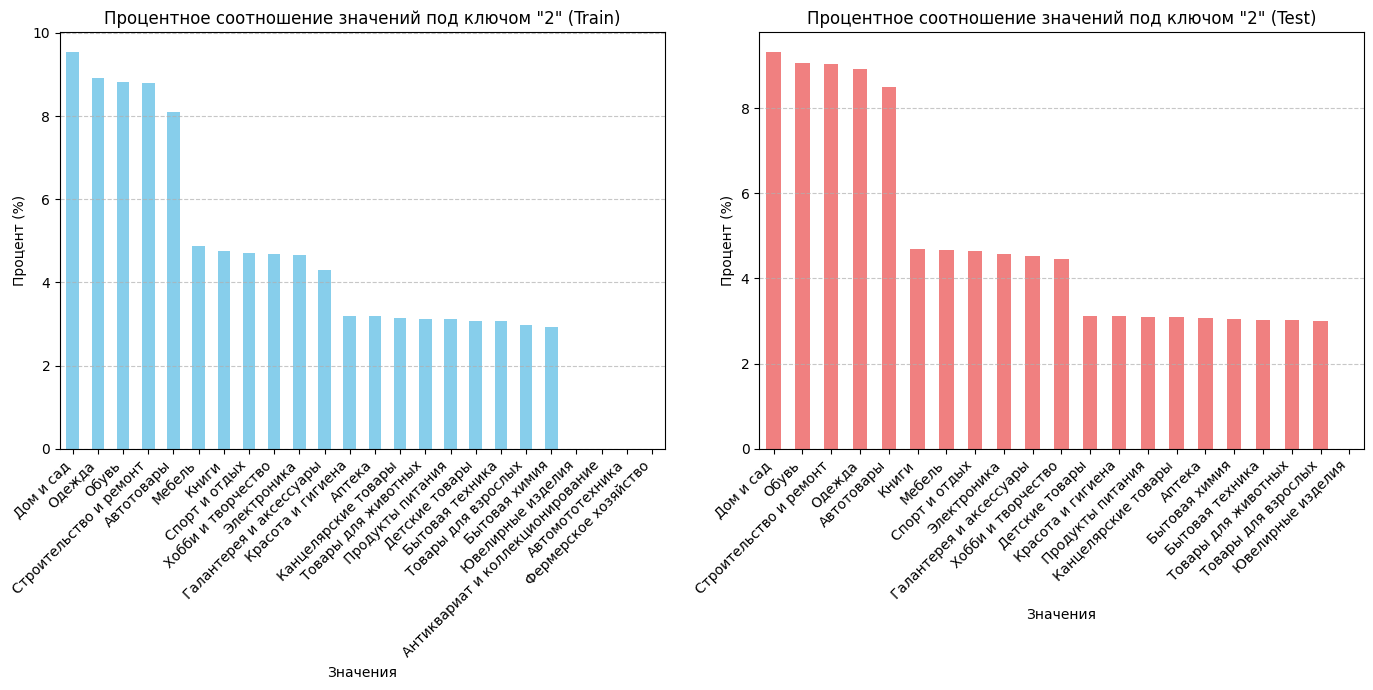

Ключ: "2"
Тренировочный датасет - Уникальные значения и их частота:
categories
Дом и сад                           214851
Одежда                              200703
Обувь                               198828
Строительство и ремонт              198109
Автотовары                          182467
Мебель                              109966
Книги                               106999
Спорт и отдых                       106036
Хобби и творчество                  105321
Электроника                         105162
Галантерея и аксессуары              97068
Красота и гигиена                    71960
Аптека                               71701
Канцелярские товары                  71032
Товары для животных                  70448
Продукты питания                     70270
Детские товары                       69399
Бытовая техника                      69197
Товары для взрослых                  66991
Бытовая химия                        66051
Ювелирные изделия                        5
Антиквариат и колл

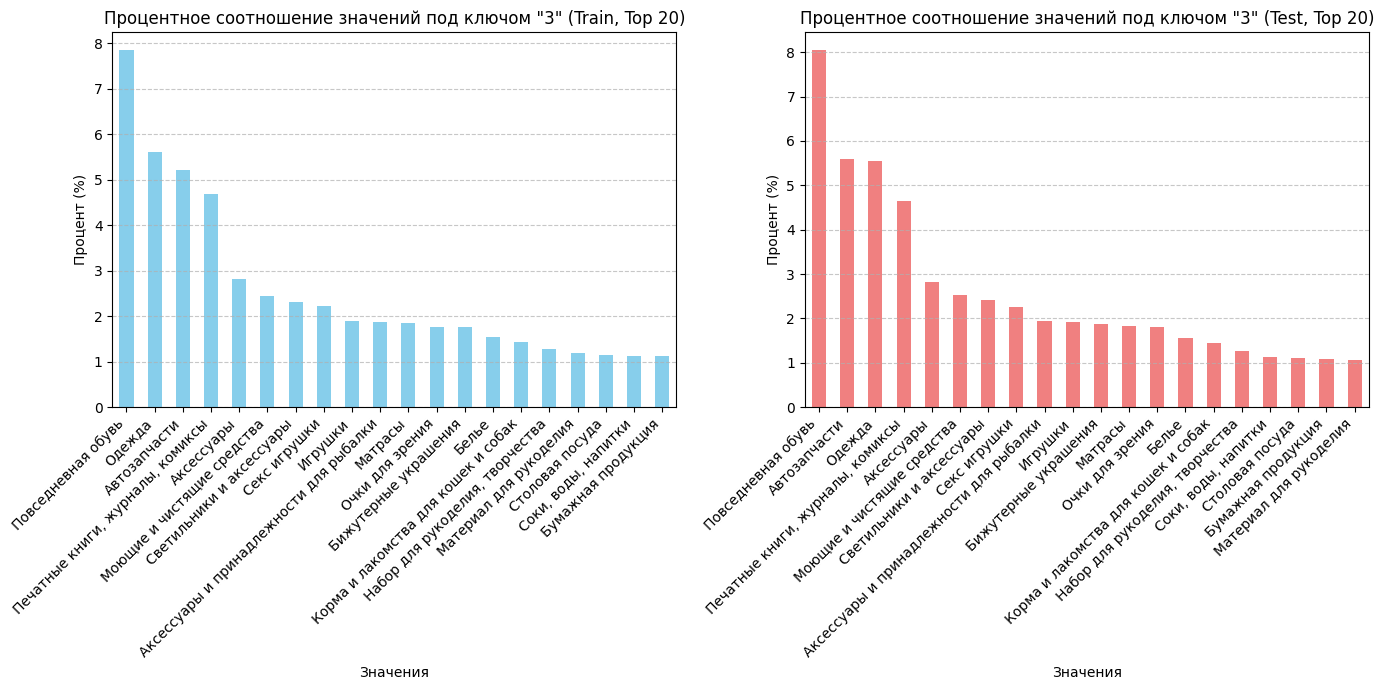

Ключ: "3"
Тренировочный датасет - Уникальные значения и их частота:
categories
Повседневная обувь                                         176865
Одежда                                                     126291
Автозапчасти                                               117480
Печатные книги, журналы, комиксы                           105760
Аксессуары                                                  63486
                                                            ...  
Коллекционирование                                              1
Аудиокниги на физическом носителе                               1
Расходные материалы для оборудования, техники, приборов         1
Гипсокартон и листовые материалы                                1
Демонстрационное оборудование                                   1
Name: count, Length: 583, dtype: int64

Тестовый датасет - Уникальные значения и их частота:
categories
Повседневная обувь                             18636
Автозапчасти                          

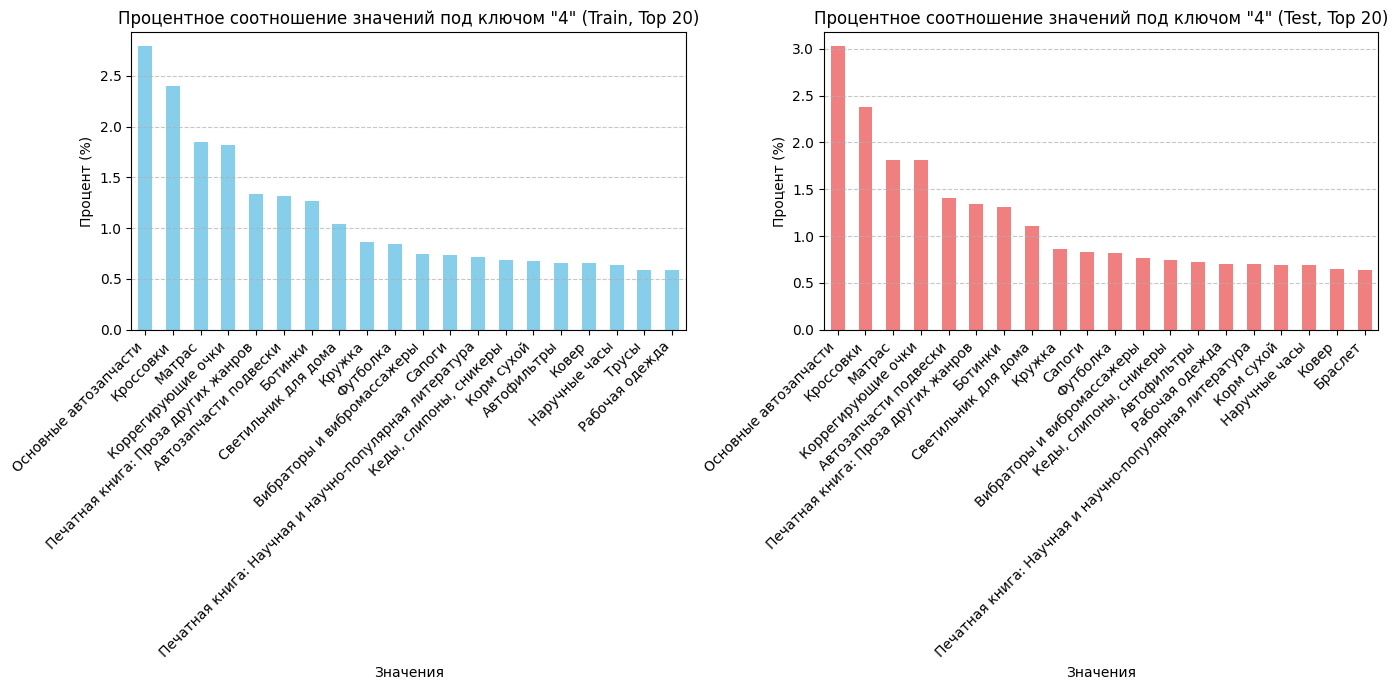

Ключ: "4"
Тренировочный датасет - Уникальные значения и их частота:
categories
Основные автозапчасти                      62806
Кроссовки                                  54117
Матрас                                     41523
Коррегирующие очки                         40916
Печатная книга: Проза других жанров        30194
                                           ...  
Аккумулятор для моноколеса, гироскутера        1
Шары для лототрона                             1
Сумка ланчбокс                                 1
Виброгаситель                                  1
Запечатывающее устройство                      1
Name: count, Length: 3686, dtype: int64

Тестовый датасет - Уникальные значения и их частота:
categories
Основные автозапчасти                 7002
Кроссовки                             5510
Матрас                                4205
Коррегирующие очки                    4196
Автозапчасти подвески                 3252
                                      ... 
Автоклавы и стерили

In [170]:
# Создаем графики для каждого ключа
for key in unique_keys:
    # Для трейна
    train_values = attributes_train['categories'].apply(lambda x: x.get(key))
    train_unique_values = train_values.value_counts()
    train_percentage = (train_unique_values / train_unique_values.sum()) * 100
    
    # Для теста
    test_values = attributes_test['categories'].apply(lambda x: x.get(key))
    test_unique_values = test_values.value_counts()
    test_percentage = (test_unique_values / test_unique_values.sum()) * 100

    # Построение графиков
    plt.figure(figsize=(14, 7))
    
    # Тренировочный датасет
    plt.subplot(1, 2, 1)
    
    # Подписываем только первые 10 значений для категорий 3 и 4
    if key in ['3', '4']:
        train_percentage.head(20).plot(kind='bar', color='skyblue')
        plt.title(f'Процентное соотношение значений под ключом "{key}" (Train, Top 20)')
    else:
        train_percentage.plot(kind='bar', color='skyblue')
        plt.title(f'Процентное соотношение значений под ключом "{key}" (Train)')
    
    plt.xlabel('Значения')
    plt.ylabel('Процент (%)')
    plt.xticks(rotation=45, ha='right')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Тестовый датасет
    plt.subplot(1, 2, 2)
    
    if key in ['3', '4']:
        test_percentage.head(20).plot(kind='bar', color='lightcoral')
        plt.title(f'Процентное соотношение значений под ключом "{key}" (Test, Top 20)')
    else:
        test_percentage.plot(kind='bar', color='lightcoral')
        plt.title(f'Процентное соотношение значений под ключом "{key}" (Test)')
    
    plt.xlabel('Значения')
    plt.ylabel('Процент (%)')
    plt.xticks(rotation=45, ha='right')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

    # Вывод результатов
    print(f'Ключ: "{key}"')
    print(f'Тренировочный датасет - Уникальные значения и их частота:\n{train_unique_values}\n')
    print(f'Тестовый датасет - Уникальные значения и их частота:\n{test_unique_values}\n')
    print(f'Тренировочный датасет - Процентное соотношение:\n{train_percentage}\n')
    print(f'Тестовый датасет - Процентное соотношение:\n{test_percentage}\n')


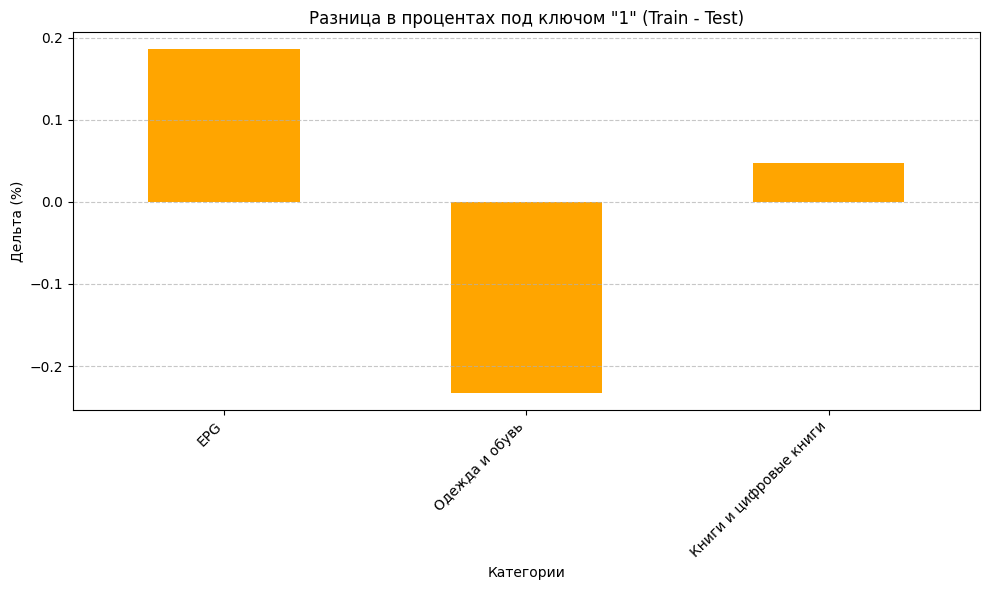

Ключ: "1"
Разница в проценте (Train - Test):
categories
EPG                       0.185488
Одежда и обувь           -0.232375
Книги и цифровые книги    0.046887
Name: count, dtype: float64



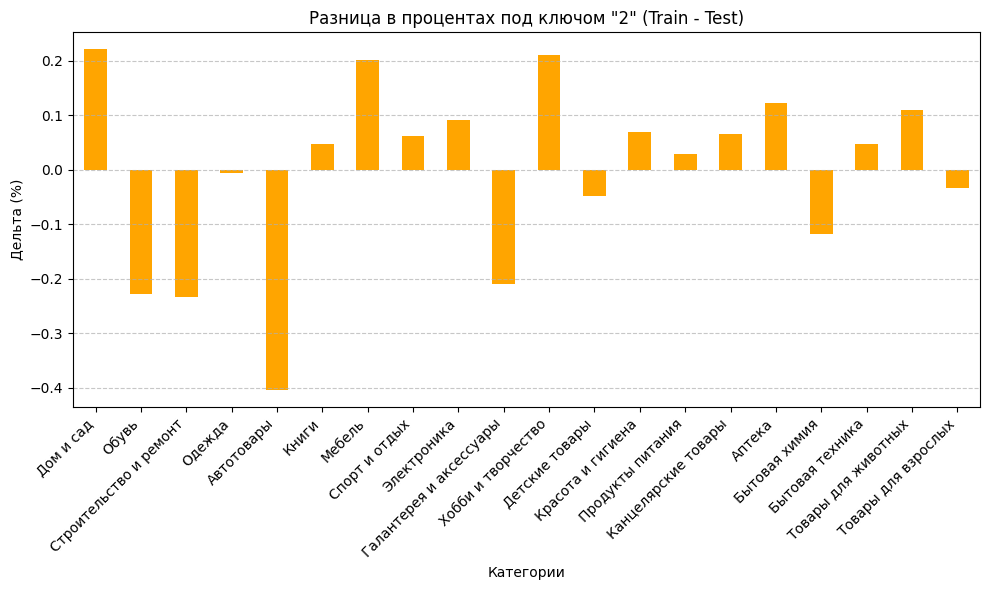

Ключ: "2"
Разница в проценте (Train - Test):
categories
Автомототехника                     0.000089
Автотовары                         -0.403968
Антиквариат и коллекционирование    0.000089
Аптека                              0.122888
Бытовая техника                     0.047134
Бытовая химия                      -0.117574
Галантерея и аксессуары            -0.209175
Детские товары                     -0.047100
Дом и сад                           0.221026
Канцелярские товары                 0.065985
Книги                               0.046887
Красота и гигиена                   0.069615
Мебель                              0.201058
Обувь                              -0.226895
Одежда                             -0.005480
Продукты питания                    0.029566
Спорт и отдых                       0.061566
Строительство и ремонт             -0.233338
Товары для взрослых                -0.033527
Товары для животных                 0.109147
Фермерское хозяйство                0.000044

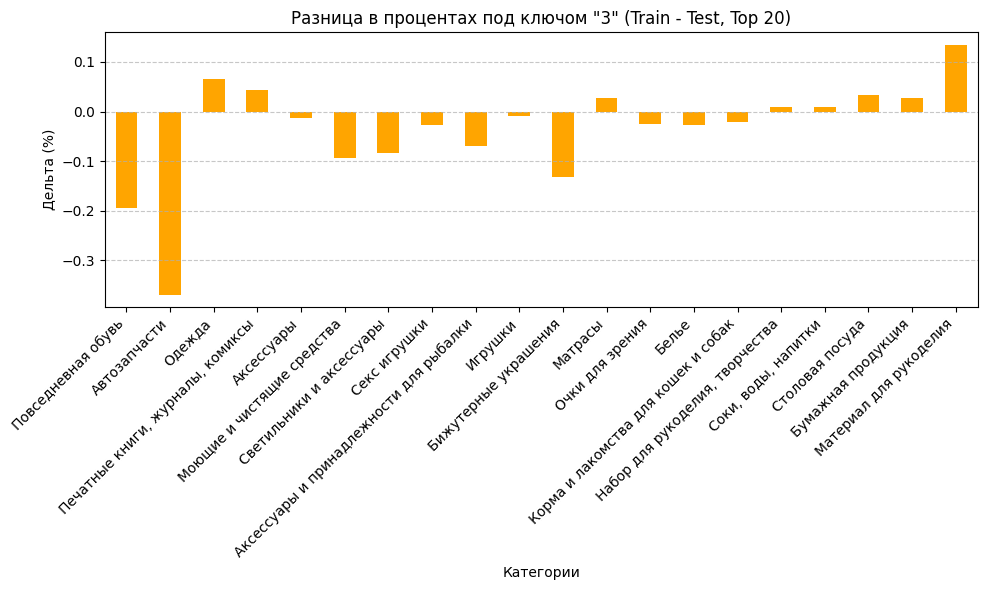

Ключ: "3"
Разница в проценте (Train - Test):
categories
(Don't use) Гаджеты и аксессуары для спорта   -0.000319
(Don't use) Комплектующие для мебели           0.001287
(Don't use) Мебель для салонов красоты        -0.001316
(Don't use) Мебель для хранения алкоголя       0.000444
(Don't use) Пуфики и банкетки                  0.002087
                                                 ...   
Электротранспорт                              -0.000585
Электроустановочные изделия                   -0.038586
Эпиляторы                                      0.000073
Эхолоты и аксессуары                           0.000505
Ювелирные украшения                           -0.000210
Name: count, Length: 583, dtype: float64



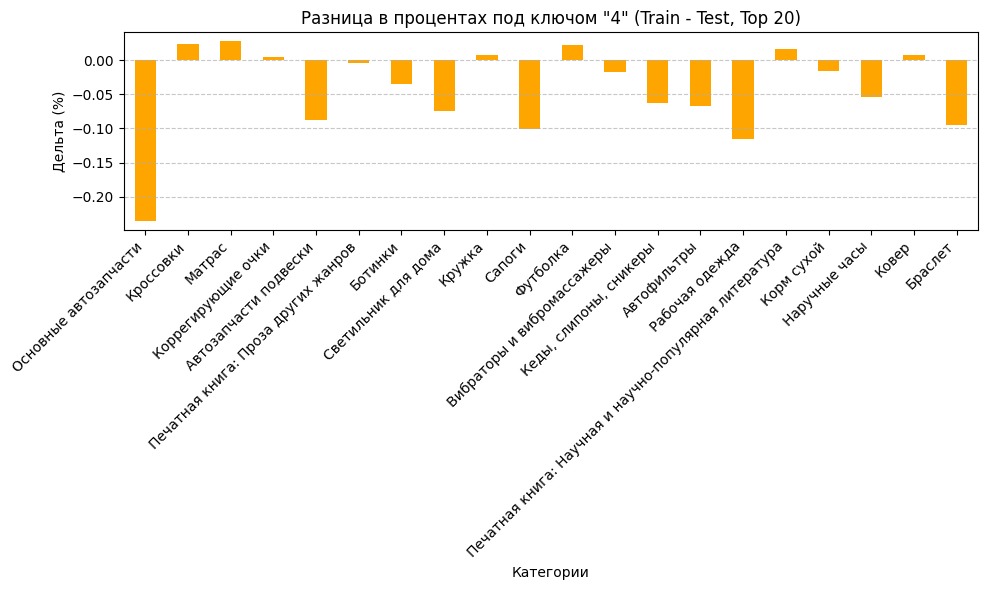

Ключ: "4"
Разница в проценте (Train - Test):
categories
(don't use)Эротический сувенир, подушка для секса    0.000044
(ВЕТ) Вакцины и уколы для животных                   0.000989
(ВЕТ) Витамины для животных                         -0.001227
(ВЕТ) Гомеопатия                                     0.000044
(ВЕТ) Гормональные препараты                        -0.000839
                                                       ...   
Ящик для игрушек                                     0.002514
Ящик для инструментов                                0.003524
Ящик для патронов                                    0.000044
Ящик для рыбалки                                     0.001337
Ящик для хранения денег                              0.000089
Name: count, Length: 3686, dtype: float64



In [175]:

# Создаем графики для каждого ключа по дельте процентов
for key in unique_keys:
    # Для трейна
    train_values = attributes_train['categories'].apply(lambda x: x.get(key))
    train_unique_values = train_values.value_counts()
    train_percentage = (train_unique_values / train_unique_values.sum()) * 100
    
    # Для теста
    test_values = attributes_test['categories'].apply(lambda x: x.get(key))
    test_unique_values = test_values.value_counts()
    test_percentage = (test_unique_values / test_unique_values.sum()) * 100
    
    # Выравниваем индексы для расчета разницы (добавляем недостающие индексы)
    all_categories = train_percentage.index.union(test_percentage.index)
    train_percentage = train_percentage.reindex(all_categories, fill_value=0)
    test_percentage = test_percentage.reindex(all_categories, fill_value=0)
    
    # Рассчитываем разницу в процентах (дельту)
    difference_percentage = train_percentage - test_percentage


   #Для 3 и 4 уровня:
    # Оставляем только общие категории, ориентируясь на топ-20 теста
    common_categories = train_percentage.index.intersection(test_percentage.index)
    train_percentage_34 = train_percentage[common_categories]
    test_percentage_34 = test_percentage[common_categories]
    
    # Сортировка по тесту и выбор топ-20 категорий
    top_20_categories = test_percentage_34.nlargest(20).index
    train_percentage_top20 = train_percentage_34[top_20_categories]
    test_percentage_top20 = test_percentage_34[top_20_categories]
    
    # Рассчитываем разницу в процентах (дельту)
    difference_percentage20 = train_percentage_top20 - test_percentage_top20
   
    plt.figure(figsize=(10, 6))
    
    if key in ['3', '4']:
        difference_percentage20.head(20).plot(kind='bar', color='orange')
        plt.title(f'Разница в процентах под ключом "{key}" (Train - Test, Top 20)')
    else:
        difference_percentage20.plot(kind='bar', color='orange')
        plt.title(f'Разница в процентах под ключом "{key}" (Train - Test)')
    
    plt.xlabel('Категории')
    plt.ylabel('Дельта (%)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

    # Вывод результатов
    print(f'Ключ: "{key}"')
    print(f'Разница в проценте (Train - Test):\n{difference_percentage}\n')


### Обработчик для библитеки поларс!

In [152]:
def drop_duplicates(df: pl.DataFrame) -> pl.DataFrame:
# Преобразуем столбцы в фиксированные списки
    df = df.with_columns(pl.DataFrame({
        'sorted_variants': [
            sorted([row['variantid1'], row['variantid2']])
            for row in df.to_dicts()
        ]
    }).get_column('sorted_variants').alias('sorted_variants'))

# Находим дубликаты, где target различен (то есть в колонке  count будет значение 2)
    df_with_counts = df.with_columns(
        # Считаем количество различных значений target для каждой комбинации sorted_variants
        pl.col('target').n_unique().over('sorted_variants').alias('count')
    )
# Удяляем все дубликаты с разными таргетами
    df_filtered = df_with_counts.filter(pl.col('count')== 1)
# Удаляем дубли, где sorted_variants одинаковы
    df_unique = df_filtered.unique(subset=['sorted_variants'])
# Удаляем вспомогательные столбцы sorted_variants и count
    df_final = df_unique.drop(['sorted_variants', 'count'])

    return df_final

# Тест
df = pl.DataFrame({
    'variantid1': [1, 2, 1, 2, 3, 3, 3],
    'variantid2': [2, 1, 2, 1, 4, 4, 5],
    'target': [0, 1, 1, 1, 0, 0, 1]
})
processed_df = drop_duplicates(df)
print(processed_df)


shape: (2, 3)
┌────────────┬────────────┬────────┐
│ variantid1 ┆ variantid2 ┆ target │
│ ---        ┆ ---        ┆ ---    │
│ i64        ┆ i64        ┆ i64    │
╞════════════╪════════════╪════════╡
│ 3          ┆ 4          ┆ 0      │
│ 3          ┆ 5          ┆ 1      │
└────────────┴────────────┴────────┘


#### Удаление дублей из трейна и сохранение в новый паркет

In [22]:
train_clean=delete_duples(train)
train_clean.to_parquet('train_no_duples.parquet', index=False)
train_clean.info()

/var/folders/nz/msyc715j0tx2ql6fblq1vm7h0000gn/T/ipykernel_76031/2851992409.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_duplicates = duplicate_groups.groupby('sorted_variants').apply(lambda x: {


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1163396 entries, 0 to 1163395
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   variantid1  1163396 non-null  int64
 1   variantid2  1163396 non-null  int64
 2   target      1163396 non-null  int64
dtypes: int64(3)
memory usage: 26.6 MB


In [23]:
id_with_extra_cat=[1083334459, 317662401, 863946390, 514715802, 833622492]
# Удаление строк, где variantid1 или variantid2 содержат значения из категорий, которых нет в тесте
train_clean_2 = train_clean[
    ~train_clean['variantid1'].isin(id_with_extra_cat) & 
    ~train_clean['variantid2'].isin(id_with_extra_cat)
]


train_clean_2.to_parquet('train_no_duples_noextra_cat.parquet', index=False)
train_clean_2.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1163392 entries, 0 to 1163395
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   variantid1  1163392 non-null  int64
 1   variantid2  1163392 non-null  int64
 2   target      1163392 non-null  int64
dtypes: int64(3)
memory usage: 35.5 MB


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168516 entries, 0 to 1168515
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   variantid1  1168516 non-null  int64
 1   variantid2  1168516 non-null  int64
 2   target      1168516 non-null  int64
dtypes: int64(3)
memory usage: 26.7 MB


## Unpacking dictionary with LabelEncoder (hidden part)

In [21]:
attributes_test.head()

,variantid,characteristic_attributes_mapping,category_0,category_1,category_2,category_3,combined_text
2,49853444,Бренд Vervaco Тип Набор для вышивания Страна-и...,0,19,282,1463,Бренд Vervaco Тип Набор для вышивания Страна-и...
3,49893028,"Цвет товара серый Ширина, см 0.8 Бренд Prym Ти...",0,19,292,2525,"Цвет товара серый Ширина, см 0.8 Бренд Prym Ти..."
28,55077096,Цвет товара золотой Название цвета Золотистая ...,0,8,217,1112,Цвет товара золотой Название цвета Золотистая ...
31,55826147,Артикул DM-160242-4 Размер одежды/аксессуара д...,0,18,307,1631,Артикул DM-160242-4 Размер одежды/аксессуара д...
44,58795249,Тип Контактные линзы Страна-изготовитель Ирлан...,0,2,209,1038,Тип Контактные линзы Страна-изготовитель Ирлан...


: 